In [1]:
import pymc as pm
import pytensor.tensor as tt
from pytensor.tensor.slinalg import cholesky
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from Bio import Phylo

In [2]:
newick="((Mus_caroli:5,(Mus_spretus:2,Mus_musculus:2)Ancestor2:3)Ancestor1:45.0,(Peromyscus_californicus:10.0,((Peromyscus_leucopus:2.0,Peromyscus_gossypinus:2.0)Ancestor5:2.0,(Peromyscus_polionotus:2.0,Peromyscus_maniculatus:2.0)Ancestor6:2.0)Ancestor4:6.0)Ancestor3:40);"
tree = Phylo.read(StringIO(newick), "newick")

In [3]:
# First, calculate the current tree height (max root-to-tip distance)
def get_max_distance(tree):
    return max(tree.depths().values())

original_height = get_max_distance(tree)

# Scale all branch lengths so that the height becomes 1
scaling_factor = 1.0 / original_height

for clade in tree.find_clades():
    if clade.branch_length:
        clade.branch_length *= scaling_factor

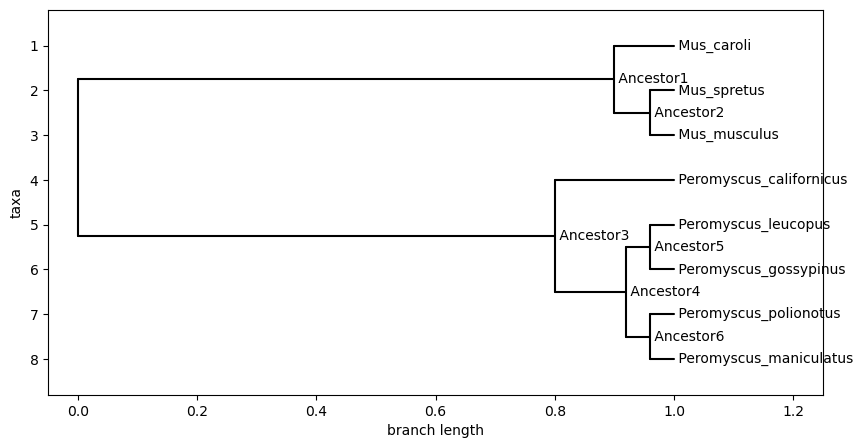

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
Phylo.draw(tree, axes=ax, do_show=False)
plt.show()

### Create Synthetic Behavior Dataframe

In [5]:
def simulate_behavior_data(
    newick: str,
    n_behaviors: int = 25,
    n_species_samples: int = 20,
    process: str = "brownian",
    alpha: float = 1.0,
    seed: int = 42,
    n_clusters: int = 5,
    Va_cov = 0.8, 
    Ve_cov = 0.6
):
    """
    Simulate log-prob behavior data for multiple species and individuals.
    Uses Biopython for all phylogenetic computations.

    Returns:
      df: DataFrame of simulated log-behaviors,
      V_a: ground-truth phylogenetic covariance matrix,
      V_e: ground-truth individual-state covariance matrix,
      phylo_cluster: array of cluster IDs for each behavior (phylogenetic clusters),
      state_cluster: array of cluster IDs for each behavior (state clusters)
      Va_cov: covariance value to set Va
    """
    rng = np.random.RandomState(seed)

    # --- Parse tree with Biopython ---
    tree = Phylo.read(StringIO(newick), "newick")
    # ensure root has zero length
    if tree.root.branch_length is None:
        tree.root.branch_length = 0.0

    # collect all tip clades
    tips = tree.get_terminals()
    m = len(tips)
    tip_names = [t.name for t in tips]

    # --- Compute patristic distance matrix D using tree.distance() ---
    D = np.zeros((m, m), float)
    for i, ti in enumerate(tips):
        for j, tj in enumerate(tips):
            D[i, j] = tree.distance(ti, tj)

    # --- Compute depths of every clade from the root, and tree height ---
    depths = tree.depths()  # dict {clade: distance-from-root}
    height = max(depths.values())

    # --- Build phylogenetic correlation A ---
    if process.lower() == "brownian":
        A = (height - D / 2.0) / height
        A = np.clip(A, 0.0, 1.0)
    elif process.lower() == "ou":
        A = np.exp(-alpha * D)
    else:
        raise ValueError("process must be 'brownian' or 'OU'")
    # scale to correlation matrix
    diag = np.sqrt(np.diag(A))
    A = A / diag[:, None] / diag[None, :]

    # --- Generate true clusters ---
    cluster_size = n_behaviors // n_clusters
    perm1 = rng.permutation(n_behaviors)
    perm2 = rng.permutation(n_behaviors)
    phylo_cluster = np.zeros(n_behaviors, dtype=int)
    state_cluster = np.zeros(n_behaviors, dtype=int)
    for k in range(n_clusters):
        idx_phy = perm1[k * cluster_size : (k + 1) * cluster_size]
        idx_state = perm2[k * cluster_size : (k + 1) * cluster_size]
        phylo_cluster[idx_phy] = k
        state_cluster[idx_state] = k

    # --- Build covariance matrices V_a and V_e ---
    V_a = np.full((n_behaviors, n_behaviors), 0.1)
    for k in range(n_clusters):
        idx = np.where(phylo_cluster == k)[0]
        for i in idx:
            for j in idx:
                V_a[i, j] = Va_cov
    np.fill_diagonal(V_a, 1.0)

    V_e = np.zeros((n_behaviors, n_behaviors))
    for k in range(n_clusters):
        idx = np.where(state_cluster == k)[0]
        for i in idx:
            for j in idx:
                V_e[i, j] = Ve_cov if i != j else 1.0

    mu = np.zeros(n_behaviors)

    # --- Simulate phylogenetic random effects (rho) and residuals (E) ---
    chol_A = np.linalg.cholesky(A)
    chol_Va = np.linalg.cholesky(V_a)
    Z = rng.normal(size=(m, n_behaviors))
    # phylogenetic effects per species
    rho = chol_A @ Z @ chol_Va.T

    chol_Ve = np.linalg.cholesky(V_e)
    E = rng.normal(size=(m, n_species_samples, n_behaviors))
    for s in range(m):
        E[s] = E[s] @ chol_Ve.T

    # --- Assemble DataFrame ---
    rows = []
    for i, sp in enumerate(tip_names):
        for j in range(n_species_samples):
            ell = mu + rho[i] + E[i, j]
            row = {"species": sp, "individual": j}
            row.update({f"behavior_{b}": ell[b] for b in range(n_behaviors)})
            rows.append(row)
    df = pd.DataFrame(rows)

    return df, V_a, V_e, phylo_cluster, state_cluster

In [6]:
true_alpha = 5

In [7]:
df, Va, Ve, phylo_cluster, state_cluster = simulate_behavior_data(
    newick=newick,
    n_behaviors=25,
    n_species_samples=20,
    process="OU",
    alpha=true_alpha,
    seed=1
)

In [8]:
df[:3]

,species,individual,behavior_0,behavior_1,behavior_2,behavior_3,behavior_4,behavior_5,behavior_6,behavior_7,...,behavior_15,behavior_16,behavior_17,behavior_18,behavior_19,behavior_20,behavior_21,behavior_22,behavior_23,behavior_24
0,Mus_caroli,0,1.426799,1.408050,-1.397605,-0.271372,0.030511,0.145672,-0.004017,1.955509,...,1.113027,-0.357116,1.765843,-0.299543,-2.493144,0.325618,0.159577,1.570124,0.298083,0.621909
1,Mus_caroli,1,1.862176,1.429138,-2.143075,0.473633,-1.552890,-0.421803,1.337038,2.079306,...,-0.362490,1.939218,-2.071180,-1.051518,-0.830734,2.919688,1.432694,2.010476,0.884690,-0.092291
2,Mus_caroli,2,2.810182,1.773109,1.364449,0.034566,-1.297634,-0.646852,0.947613,2.387584,...,2.442095,2.386358,-0.936924,-1.025325,0.651286,3.586471,1.705498,1.693202,2.311245,0.725599


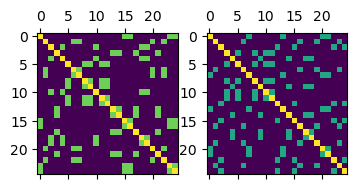

In [9]:
fig, axs = plt.subplots(figsize=(4,2), ncols=2)
axs[0].matshow(Va)
axs[1].matshow(Ve)

In [10]:
from scipy.stats import pearsonr

In [11]:
pearsonr(Va[np.tril_indices(len(Va), -1)], Ve[np.tril_indices(len(Ve), -1)])

PearsonRResult(statistic=np.float64(0.03999999999999998), pvalue=np.float64(0.49006571481203975))

In [12]:
behavior_cols = [c for c in df.columns if c.startswith("behavior_")]
Y = df[behavior_cols].values
n_obs, K = Y.shape

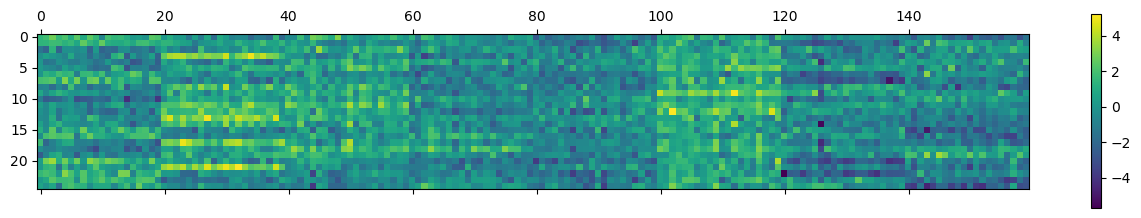

In [13]:
plt.matshow(Y.T)
plt.colorbar()

### Create OU matrix

In [14]:
from Bio.Phylo.BaseTree import Clade

def collect_all_nodes(tree):
    """
    Return a list of *all* nodes in the tree, each node having a .name
    (set for tips and internal nodes).
    """
    # Ensure each node has a unique .name, e.g. for internal nodes, we might do something like:
    # "oldmela", "oldsim", etc. If the tree lacks node names, you can auto-assign them.
    all_nodes = []
    def visit(clade):
        all_nodes.append(clade)
        for child in clade.clades:
            visit(child)
    visit(tree.root)
    return all_nodes

all_nodes = collect_all_nodes(tree)  # includes tips + internals
# Optionally filter out the root if you want a separate parameter for the root,
# but let's keep it for a full approach.
tips = all_nodes[1:]
m = len(tips)

# build an OU distance or raw-patristic matrix
D = np.zeros((m, m))
for i, ti in enumerate(tips):
    for j, tj in enumerate(tips):
        D[i,j] = tree.distance(ti, tj)

In [15]:
node_to_idx = {clade.name: idx for idx, clade in enumerate(tips)}
species_idx = df['species'].map(node_to_idx).values

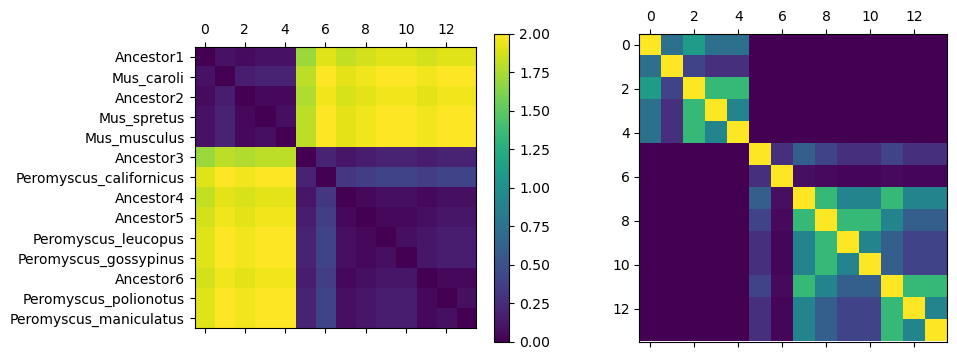

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
ax = axs[0]
cax = ax.matshow(D)
ax.set_yticks(np.arange(len(tips)))
ax.set_yticklabels(tips)
plt.colorbar(cax)
ax = axs[1]
A_gt = np.exp(-10 * D)
ax.matshow(A_gt)

### Fit model

In [17]:
from pytensor.tensor.slinalg import cholesky

In [18]:
with pm.Model() as fullrank_glmm:
    # 1) OU phylogenetic kernel
    alpha = pm.Uniform("alpha", 0.1, 10.0)
    D_shared = pm.Data("D_shared", D)
    A = pm.Deterministic(
        "A",
        tt.exp(-alpha * D_shared)
        + 1e-3 * tt.eye(m)
    )
    chol_A = cholesky(A)
    
    # 2) Common‐ancestor mean
    mu = pm.Normal("mu", 0.0, 1.0, shape=K)

    # 3) Full‐rank prior for V_a
    L_va, _, _ = pm.LKJCholeskyCov(
        "L_va",
        n=K,
        eta=1.0,
        sd_dist=pm.HalfCauchy.dist(2.5),
        compute_corr=True,
    )
    V_a = pm.Deterministic("V_a", L_va @ L_va.T + 1e-6 * tt.eye(K))
    
    # 4) Phylogenetic random effects 
    z_nodes = pm.Normal("z_nodes", mu = 0.0, sigma = 1.0, shape=(m, K))
    phylo = pm.math.dot(chol_A, z_nodes) # species–species corr
    rho = pm.math.dot(phylo, L_va.T)# trait–trait cov

    # 5) Residual covariance V(e)
    L_ve, _, _ = pm.LKJCholeskyCov(
        "L_ve",
        n=K,
        eta=1.0,
        sd_dist=pm.HalfCauchy.dist(2.5),
        compute_corr=True
    )
    V_e = pm.Deterministic("V_e", L_ve @ L_ve.T + 1e-6 * tt.eye(K))

    # 6) Likelihood
    mu_phy = rho[species_idx] + mu
    obs = pm.MvNormal(
        "obs",
        mu=mu_phy,
        chol=L_ve,
        shape=(n_obs, K),
        observed=Y,
    )

    # 7) Sample
    trace = pm.sample(
        draws=2000, # increase 
        tune=500, # increase
        target_accept=0.9, # increase
        chains=1,
        cores=1,
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, mu, L_va, z_nodes, L_ve]


Output()

/home/peromoseq/anaconda3/envs/bambi/lib/python3.12/site-packages/pytensor/tensor/subtensor.py:2585: 
RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)

Sampling 1 chain for 500 tune and 2_000 draw iterations (500 + 2_000 draws total) took 347 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Analyze results

In [19]:
alpha = np.mean(trace.posterior["alpha"].values, axis=(0,1))          # shape (chains, draws, K)
print(alpha)

9.056638202934112


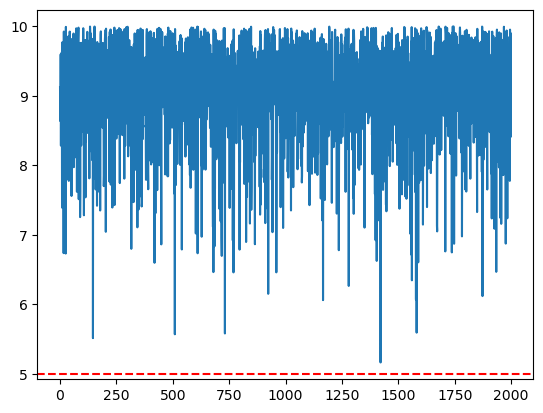

In [20]:
fig, ax = plt.subplots()
ax.plot(trace.posterior["alpha"].values.T)
ax.axhline(true_alpha, color = 'red', ls='dashed')

In [21]:
V_a = np.mean(trace.posterior["V_a"].values, axis=(0,1))          # shape (chains, draws, K)
V_e = np.mean(trace.posterior["V_e"].values, axis=(0,1))         # shape (chains, draws, K)

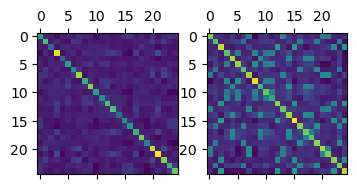

In [22]:
fig, axs = plt.subplots(figsize=(4,2), ncols=2)
axs[0].matshow(V_a)
axs[1].matshow(V_e)

In [23]:
# compare empirical to ground truth from synthetic
Va_empirical = V_a[np.tril_indices(len(Va), -1)]
Va_ground_truth = Va[np.tril_indices(len(Va), -1)]
Ve_empirical = V_e[np.tril_indices(len(Ve), -1)]
Ve_ground_truth = Ve[np.tril_indices(len(Ve), -1)]

r_va = pearsonr(Va_ground_truth, Va_empirical)
print(r_va)

r_ve =pearsonr(Ve_ground_truth, Ve_empirical)
print(r_ve)

PearsonRResult(statistic=np.float64(0.7113579238806688), pvalue=np.float64(1.4871352187759475e-47))
PearsonRResult(statistic=np.float64(0.9406820037070869), pvalue=np.float64(6.321548059410609e-142))


Text(0.5, 1.0, 'Ve')

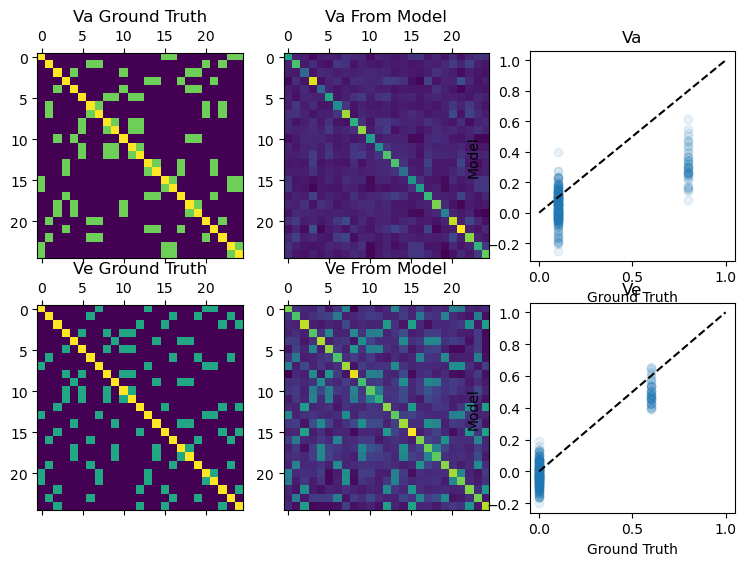

In [24]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9,6))

axs[0,0].matshow(Va)
axs[0,0].set_title('Va Ground Truth')

axs[0,1].matshow(V_a)
axs[0,1].set_title('Va From Model')

axs[0,2].scatter(
    Va_ground_truth,
    Va_empirical,
    alpha = 0.1,
)
axs[0,2].set_xlabel('Ground Truth')
axs[0,2].set_ylabel('Model')
axs[0,2].set_title('Va')
axs[0,2].plot([0,1], [0,1], color='k', ls='dashed')

axs[1,0].matshow(Ve)
axs[1,0].set_title('Ve Ground Truth')
axs[1,1].matshow(V_e)
axs[1,1].set_title('Ve From Model')
axs[1,2].scatter(
    Ve_ground_truth,
    Ve_empirical,
    alpha = 0.1,
)
axs[1,2].plot([0,1], [0,1], color='k', ls='dashed')
axs[1,2].set_xlabel('Ground Truth')
axs[1,2].set_ylabel('Model')
axs[1,2].set_title('Ve')

### Check predictions

In [25]:
ppc = pm.sample_posterior_predictive(
    trace,
    model=fullrank_glmm
)

Sampling: [obs]


Output()

In [26]:
Y_obs = Y  # Your original dataset (NxB matrix)
Y_pred = np.mean(ppc.posterior_predictive["obs"], axis=(0, 1))  # Taking mean over draws & chains

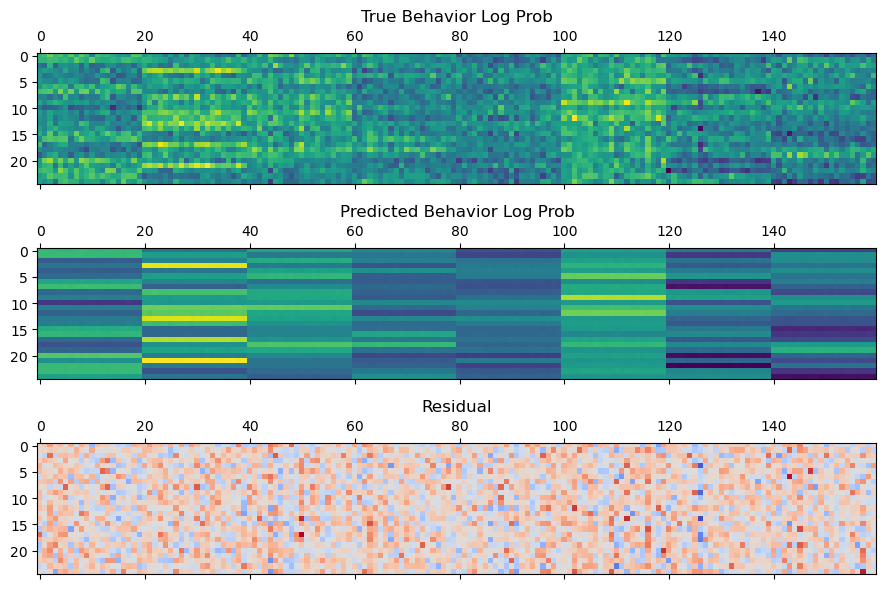

In [27]:
fig, axs= plt.subplots(nrows=3, figsize=(20,6))
cmap = 'viridis'
axs[0].matshow(Y_obs.T, cmap=cmap)
axs[0].set_title('True Behavior Log Prob')
axs[1].matshow(Y_pred.T, cmap=cmap)
axs[1].set_title('Predicted Behavior Log Prob')
axs[2].matshow(Y_obs.T - Y_pred.T, cmap='coolwarm')
axs[2].set_title('Residual')
plt.tight_layout()

### Cluster covariance matrix Va

In [28]:
import copy
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering

In [29]:
# Assume V_a is a covariance matrix
# Convert it to a correlation matrix first
D = np.corrcoef(V_a)

# Compute a distance matrix: 1 - correlation
distance_matrix = 1 - D

# Convert to condensed form for linkage
condensed = squareform(distance_matrix, checks=False)

# Perform hierarchical clustering
Z = linkage(condensed, method='average')

# Apply optimal leaf ordering
Z_opt = optimal_leaf_ordering(Z, condensed)

# Get reordered indices
ordered_indices = leaves_list(Z_opt)

# Reorder the covariance matrix
V_a_reordered = V_a[np.ix_(ordered_indices, ordered_indices)]

Text(0.5, 1.0, 'Ground Truth $V^a$')

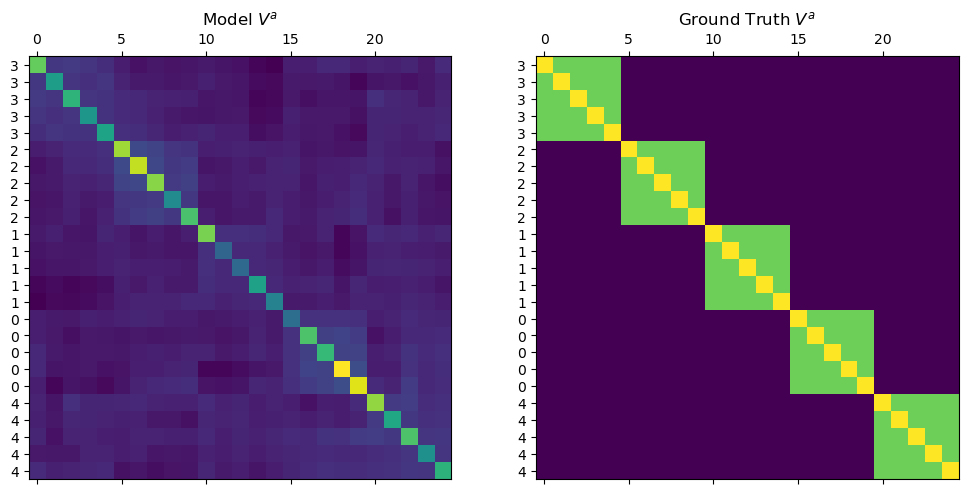

In [30]:
fig, axs = plt.subplots(figsize=(12,6), ncols=2)
ax = axs[0]
ax.matshow(V_a_reordered, cmap='viridis')
ax.set_yticks(np.arange(len(Va)))
ax.set_yticklabels(phylo_cluster[ordered_indices]);
ax.set_title('Model $V^a$')

ax = axs[1]
ax.matshow(Va[np.ix_(ordered_indices, ordered_indices)], cmap='viridis')
ax.set_yticks(np.arange(len(Va)))
ax.set_yticklabels(phylo_cluster[ordered_indices]);
ax.set_title('Ground Truth $V^a$')